In [12]:
import matplotlib.pyplot as plt

In [13]:
import random
import itertools
import numpy as np

In [14]:
# algorithm parameters
numCoeffs = 41
populationSize = 100
generations = 50
mutationRate = 0.15
functionRange = (-np.pi, np.pi)
sampleCount = 100

In [15]:
# These functions are given as samples to use in the algorithm
def getTargetFunction(functionName="sin_cos"):
    def sinCosFunction(t):
        """Target function: sin(2πt) + 0.5*cos(4πt)."""
        return np.sin(2 * np.pi * t) + 0.5 * np.cos(4 * np.pi * t)

    def linearFunction(t):
        """Simple linear function: y = 2t + 1."""
        return 2 * t + 1

    def quadraticFunction(t):
        """Quadratic function: y = 4t^2 - 4t + 2."""
        return 4 * (t**2) - 4 * t + 2

    def cubicFunction(t):
        """Cubic function: y = 8t^3 - 12t^2 + 6t."""
        return 8 * (t**3) - 12 * (t**2) + 6 * t

    def gaussianFunction(t):
        """Gaussian function centered at t=0.5."""
        mu = 0.5
        sigma = 0.1  # Adjust sigma to control the width of the peak
        return np.exp(-((t - mu) ** 2) / (2 * sigma**2))

    def squareWaveFunction(t):
        """Approximation of a square wave. Smoothed for better Fourier approximation."""
        return 0.5 * (np.sign(np.sin(2 * np.pi * t)) + 1)

    def sawtoothFunction(t):
        """Sawtooth wave, normalized to [0, 1]."""
        return (t * 5) % 1

    def complexFourierFunction(t):
        return (
            np.sin(2 * np.pi * t)
            + 0.3 * np.cos(4 * np.pi * t)
            + 0.2 * np.sin(6 * np.pi * t)
            + 0.1 * np.cos(8 * np.pi * t)
        )

    def polynomialFunction(t):
        return 10 * (t**5) - 20 * (t**4) + 15 * (t**3) - 4 * (t**2) + t + 0.5

    functionOptions = {
        "sin_cos": sinCosFunction,
        "linear": linearFunction,
        "quadratic": quadraticFunction,
        "cubic": cubicFunction,
        "gaussian": gaussianFunction,
        "square_wave": squareWaveFunction,
        "sawtooth": sawtoothFunction,
        "complex_fourier": complexFourierFunction,
        "polynomial": polynomialFunction,
    }

    selectedFunction = functionOptions.get(functionName.lower())
    if selectedFunction:
        return selectedFunction

# Part 1: Problem Introduction 
**Fourier Series Approximation using Genetic Algorithm**

Content:

In this notebook, we use a genetic algorithm (GA) to estimate the first 20 terms of the Fourier series that approximates an unknown function. We are given 100 sampled data points from the function in the interval [0, T]. The goal is to optimize the 41 Fourier coefficients (a₀, a₁–a₂₀, b₁–b₂₀) using GA.

_____________________________________________________________________________________________________________________________________________________

# Part 2: Definitions and Initial Setup
**Definitions – Genes, Chromosome, and Fourier Series**

Content:

A gene is a single Fourier coefficient.

A chromosome is a set of 41 coefficients: [a₀, a₁, ..., a₂₀, b₁, ..., b₂₀].

The fitness of a chromosome is how well it approximates the sampled data using the Fourier series:
$
f(t) \approx \frac{a_0}{2} + \sum_{n=1}^{20} \left(a_n \cos(2\pi nt) + b_n \sin(2\pi nt)\right) ]
$

In [16]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
numCoeffs = 41
populationSize = 100
generations = 50
mutationRate = 0.15
coeffRange = (-10, 10)  # A = 10
functionRange = (-np.pi, np.pi)
sampleCount = 100


_____________________________________________________________________________________________________________________________________________________

# Part 3: Sampling the Function
**Sampling the Target Function**

Content:

We choose a target function and generate 100 equally spaced samples in the interval [-π, π]. These values are used as the data for training the GA.

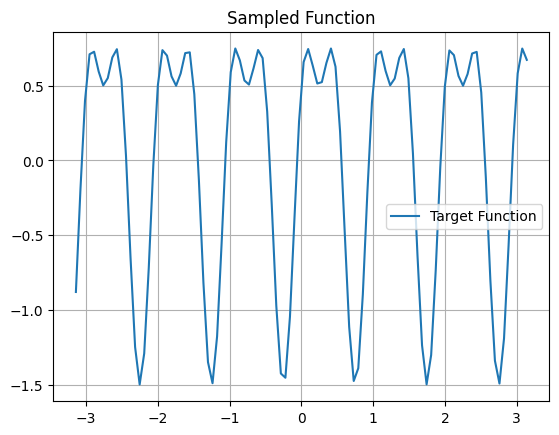

In [ ]:
def getTargetFunction(functionName="sin_cos"):
    def sinCosFunction(t): return np.sin(2 * np.pi * t) + 0.5 * np.cos(4 * np.pi * t)
    def linearFunction(t): return 2 * t + 1
    def gaussianFunction(t):
        mu, sigma = 0.5, 0.1
        return np.exp(-((t - mu) ** 2) / (2 * sigma**2))
    return {
        "sin_cos": sinCosFunction,
        "linear": linearFunction,
        "gaussian": gaussianFunction
    }.get(functionName.lower(), sinCosFunction)

# Generate sampled data
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction("sin_cos")(tSamples)

plt.plot(tSamples, fSamples, label="Target Function")
plt.title("Sampled Function")
plt.grid(True)
plt.legend()
plt.show()

_____________________________________________________________________________________________________________________________________________________

# Part 4: Initial Population
**Step 3: Initial Population Generation**

Content:

We initialize a population of chromosomes, each consisting of 41 coefficients randomly chosen from the range [-10, 10].

In [18]:
def generate_population(size, coeff_range=(-10, 10), num_coeffs=41):
    return [np.random.uniform(coeff_range[0], coeff_range[1], num_coeffs) for _ in range(size)]

population = generate_population(populationSize)


_____________________________________________________________________________________________________________________________________________________

# Part 5: Fitness Evaluation

**Step 4: Fitness Functions (RMSE, MAE, R²)**

Content:

We use three fitness evaluation metrics:

1. RMSE (Root Mean Square Error)

2. MAE (Mean Absolute Error)

3. R² Score The GA minimizes RMSE for optimization, but we track all metrics.

In [19]:
def fourier_series(chromosome, t):
    a0 = chromosome[0]
    an = chromosome[1:21]
    bn = chromosome[21:]
    result = a0 / 2
    for n in range(1, 21):
        result += an[n-1] * np.cos(n * 2 * np.pi * t) + bn[n-1] * np.sin(n * 2 * np.pi * t)
    return result

def fitness(chromosome, t_samples, f_samples):
    predictions = np.array([fourier_series(chromosome, t) for t in t_samples])
    rmse = np.sqrt(np.mean((f_samples - predictions) ** 2))
    mae = np.mean(np.abs(f_samples - predictions))
    r2 = 1 - np.sum((f_samples - predictions)**2) / np.sum((f_samples - np.mean(f_samples))**2)
    return rmse, mae, r2


_____________________________________________________________________________________________________________________________________________________

# Part 6: GA Operators

**Step 5: Crossover, Mutation, and Selection**

Content:

We use:

📄One-point crossover

📄Random mutation per gene

📄Elitism: the best individuals are kept

In [20]:
def crossover(parent1, parent2):
    point = random.randint(1, numCoeffs - 1)
    return np.concatenate([parent1[:point], parent2[point:]])

def mutate(chromosome, mutation_rate=0.15, coeff_range=(-10, 10)):
    for i in range(len(chromosome)):
        if random.random() < mutation_rate:
            chromosome[i] = np.random.uniform(*coeff_range)
    return chromosome

def select_mating_pool(population, fitnesses, num_parents):
    sorted_pop = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0])]
    return sorted_pop[:num_parents]


_____________________________________________________________________________________________________________________________________________________

# Part 7: Main GA Loop

**Step 6: Genetic Algorithm Execution**

Content:

We run the GA for a set number of generations. In each generation:

Evaluate fitness

Select parents

Generate offspring via crossover and mutation

Track the best fitness (RMSE)

In [21]:
def run_ga():
    population = generate_population(populationSize)
    best_errors = []

    for gen in range(generations):
        fitnesses = [fitness(chrom, tSamples, fSamples)[0] for chrom in population]
        best_fit = min(fitnesses)
        best_errors.append(best_fit)

        parents = select_mating_pool(population, fitnesses, populationSize // 2)

        next_gen = []
        while len(next_gen) < populationSize:
            p1, p2 = random.sample(parents, 2)
            child = crossover(p1, p2)
            child = mutate(child, mutationRate, coeffRange)
            next_gen.append(child)

        population = next_gen

    best_chrom = population[np.argmin([fitness(c, tSamples, fSamples)[0] for c in population])]
    return best_chrom, best_errors


_____________________________________________________________________________________________________________________________________________________

# Part 8: Results and Visualization

**Step 7: Result Analysis and Visualization**

Content:

We plot the original function and the GA-optimized Fourier series approximation. We also show the RMSE trend across generations.

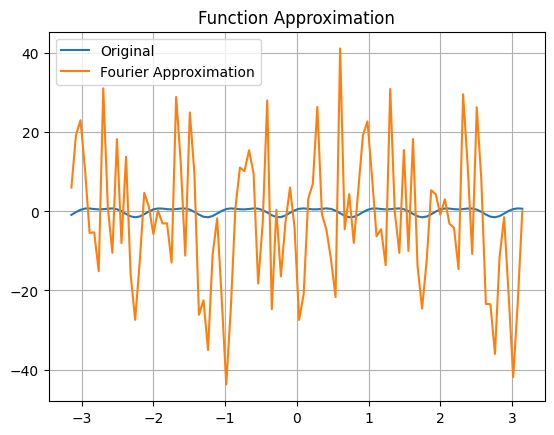

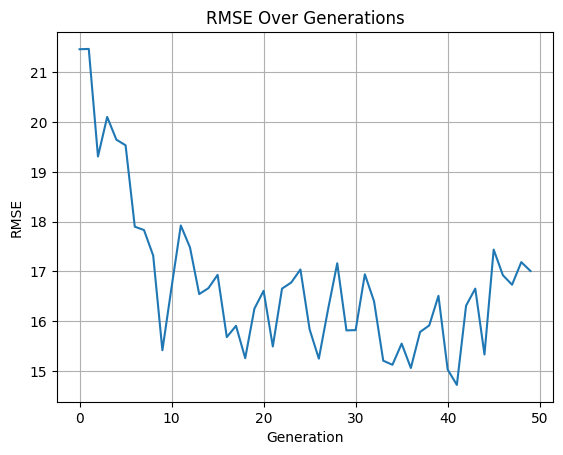

In [23]:
best_chrom, error_history = run_ga()

# Plot approximation
approx = np.array([fourier_series(best_chrom, t) for t in tSamples])
plt.plot(tSamples, fSamples, label="Original")
plt.plot(tSamples, approx, label="Fourier Approximation")
plt.legend()
plt.title("Function Approximation")
plt.grid(True)
plt.show()

# Plot RMSE over generations
plt.plot(error_history)
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.title("RMSE Over Generations")
plt.grid(True)
plt.show()
